# The Feasibility of Opening a Chinese Restaurant in Toronto and the Optimal Choice of Location

### Note: You may not be able to view the maps or graphs generated in this project on Github. As a suggestion, you can copy the link of my assignment on Github (i.e. the link that I attached in the submission window) and paste it into https://nbviewer.jupyter.org/ to get the full view of my maps. Thanks very much.

## Table of contents
* [Intoduction to the Business Problem and Background of My Project](#introduction)
* [Data](#data)
* [Data Preprocessing and Cleaning](#methodology)
* [Analysis](#analysis)
* [Conclusion](#conclusion)

## Introduction to the Business Problem and Background of My Project

The purpose of this project is to analyse the feasibility of opening a Chinese restaurant in Toronto and the optimal choice for its location. Toronto, which is one of the most beautiful and multicultural cities in Canada, attracts a lot of immigrants from different countries around the world every year and among all immigrants, Chinese make up a great proportion of the entire immigrant population. In addition, Chinese cuisine has become one of the most popular food categories in the world today. People from different countries, not just Chinese, become increasingly enthusiastic about Chinese dishes. Hence, opening a Chinese restaurant in such a great city would be a good choice for those who are thinking about opening a restaurant in Toronto.

However, opening a Chinese restaurant in Toronto could also be risky. First, due to the relatively large proportion of Chinese people in the entire immigrant population, as a owner of a new Chinese restaurant, you may have to face great pressure from other peer competitors especially if you choose to locate your restaurant in areas such as downtown or Chinatown. Second, if you choose to open your restaurant in a district where it does not have many local Chinese residents, the poor customer base may result in bad outcomes for your business. Hence, the selection of the restaurant location is extremely important for a start-up restaurant. 

The purpose of this project is to find out the best places to open a Chinese restaurant by analyzing the demographics and neighborhoods of each borough of the Toronto city. Specifically, this project will offer those who are thinking about opening a Chinese restaurant at Toronto but haven’t decided where to locate their restaurants some recommendations based on the analysis results. 

## Data

The data covered in this projects consist of four parts: (1)The List of Post codes of Canada from the Wikipedia page https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M. This dataset contain the postal code, the name and the neighbourhoods of each borough of Canada; (2) The geographical dataset downloaded from the link http://cocl.us/Geospatial_data which contains useful geographical coordinates of each postal code; (3) The dataset of the demongraphics of Toronto from the Wikipedia page https://en.m.wikipedia.org/wiki/Demographics_of_Toronto#Ethnic_diversity which provide useful information of the population compostion of each borough of the Toronto city; (4) The Foursquare's API which allows me to explore the surroundings of any specific location within the Toronto city. The endpoints that I am going to use from the Foursquare's API include the name, category, latitude as well as longitude of each venue explored.  

## Data Preprocessing and Cleaning

I need to clean up and pre-process my data before performing the analysis. First, I downloaded the tables of ‘The List of Post codes of Canada’ and ‘Geospatial data’ and merge them using post codes. The merged table contains post codes, names of boroughs, neighborhoods, latitudes and longitudes of each borough within the Toronto city. Second, I scrape the tables related to the population of ethnic origins of Toronto from the wiki page ‘Demographics of Toronto’. Lastly, I use Foursquare’s API to explore all nearby venues within the radius of 1km (up to 100) of each neighborhood. 

In order to figure out the competition pressure from other local restaurants, I filter out all restaurants from nearby venues of each neighborhood and pick out top 10 most common restaurants in that area. In addition, I further strip out all Chinese restaurants from all restaurant-relevant venues. After the cleaning process, I have 102 neighborhoods in my data. The total numbers of all restaurants and of Chinese restaurants are 821 and 13, respectively.


The following section illustrates the detailed process of data prepreparation and cleaning. 

Import all the relevant packages which will be used in this project.

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import folium
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim

In [101]:
pd.set_option('display.max_rows', df.shape[0]+1)

In [4]:
!pip install geopy

Set Toronto city as the target city for this project.

In [5]:
address = 'Toronto City, CA'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


### Scrape and clean the table of postal codes of Toronto city from Wikipedia to obtain post codes, borough names and neighbourhoods of each borough in Toronto. 

In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains all the boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

In [41]:
df = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050.')[0]
df

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
...,...,...,...
282,M8Z,Etobicoke,Mimico NW
283,M8Z,Etobicoke,The Queensway West
284,M8Z,Etobicoke,Royal York South West
285,M8Z,Etobicoke,South of Bloor


In [42]:
indexNames = df[ (df['Borough'] == 'Not assigned')].index
df.drop(indexNames, inplace=True)
df.head(11)

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
9,M9A,Etobicoke,Islington Avenue
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


In [43]:
df1 = df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
df1.head(200)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv..."
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."


In [44]:
df1.shape

(103, 3)

### Download the geographical data of Toronto which contains both latitude and longitude of each borough and combine it with the Toronto neighbourhood table

In [45]:
df_geo = pd.read_csv('http://cocl.us/Geospatial_data')
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [46]:
df_geo.rename(columns={'Postal Code':'Postcode'},inplace=True)
df_geo

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [115]:
df_merged = pd.merge(left=df1, right=df_geo, left_on='Postcode', right_on='Postcode')
df_merged.shape

(103, 5)

In [48]:
df_Toronto = df_merged[df_merged['Borough'].str.contains('Toronto',regex=False)]
df_Toronto

,Postcode,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
47,M4S,Central Toronto,Davisville,43.704324,-79.388790
48,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
49,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


### Create a map of Toronto with neighborhoods superimposed on top

In [15]:
map_toronto = folium.Map(location=[43.653963, -79.387207],zoom_start=10)

for lat,lng,borough,neighbourhood in zip(df_Toronto['Latitude'],df_Toronto['Longitude'],df_Toronto['Borough'],df_Toronto['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto

### Clustering Neighbourhoods

In [49]:
# set number of clusters
k=5
toronto_clustering = df_Toronto.drop(['Postcode','Borough','Neighbourhood'],1)

# run k-means clustering
kmeans = KMeans(n_clusters = k,random_state=0).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_
df_Toronto.insert(0, 'Cluster Labels', kmeans.labels_)
df_Toronto.drop(['Cluster Labels'],axis = 1)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
47,M4S,Central Toronto,Davisville,43.704324,-79.388790
48,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
49,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


### Exploring Neighbourhoods in Toronto

In order to explore neighbourhoods in Toronto, I am using the Foursquare' explore APIs to get all the nearby venues (up to 100) within the 1km radius of each neighbourhood.

In [103]:
# Define Foursquare accounts
CLIENT_ID = 'W2I5MM4VX5MYKME5VVEEVSX20G4N0DG4I3HP4V3QLQAYOBCT'
CLIENT_SECRET = 'INHVBROWSMCYGU3KAZITQ2EAYVKOC4HGIDY5LD00RQSSTYSP'
VERSION = '20200322'
limit = 100

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [51]:
Toronto_venues = getNearbyVenues(names=df_Toronto['Neighbourhood'],
                                   latitudes=df_Toronto['Latitude'],
                                   longitudes=df_Toronto['Longitude'])

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

In [52]:
Toronto_venues.groupby('Neighbourhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,100,100,100,100,100,100
"Brockton, Exhibition Place, Parkdale Village",100,100,100,100,100,100
Business Reply Mail Processing Centre 969 Eastern,48,48,48,48,48,48
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14
"Cabbagetown, St. James Town",38,38,38,38,38,38
Central Bay Street,100,100,100,100,100,100
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,100,100,100,100,100,100


In [53]:
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighbourhood'] = Toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head(100)

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,...,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
Toronto_venues

,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,Tori's Bakeshop,43.672114,-79.290331,Vegetarian / Vegan Restaurant
2,The Beaches,43.676357,-79.293031,The Beech Tree,43.680493,-79.288846,Gastropub
3,The Beaches,43.676357,-79.293031,The Fox Theatre,43.672801,-79.287272,Indie Movie Theater
4,The Beaches,43.676357,-79.293031,Beaches Bake Shop,43.680363,-79.289692,Bakery
...,...,...,...,...,...,...,...
3187,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,Tim Hortons,43.662644,-79.309945,Coffee Shop
3188,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,Measurement Park,43.666916,-79.312631,Park
3189,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,Breakfast Club,43.662811,-79.310174,Breakfast Spot
3190,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,Carters Landing,43.662414,-79.309898,Bistro


Since my target is to find out the best places for starting up a Chinese restaurant, I only care about the nearby restaurants of each neighbourhood. So I clean up my data by keeping only restaurant-relevant venues (i.e. venues with a name containing 'restaurant') and remove all other venues. In addition, in order to figure out the competition condition between Chinese restaurants, I further clean up my data by keeping only Chinese restaurants. 

## Analysis

### Filter for 'Chinese Restaurants' from all nearby venues of each neighbourhood

In [95]:
Chinese_venues = Toronto_venues.loc[Toronto_venues['Venue Category'] == 'Chinese Restaurant']
Borough = df_Toronto[['Borough','Neighbourhood']]
Chinese_venues = pd.merge(left = Borough, right = Chinese_venues, left_on ='Neighbourhood', right_on = 'Neighbourhood')
Chinese_venues

,Borough,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,Number One Chinese Restaurant,43.684586,-79.346910,Chinese Restaurant
1,East Toronto,Studio District,43.659526,-79.340923,Mean Bao,43.659232,-79.348011,Chinese Restaurant
2,Central Toronto,Davisville North,43.712751,-79.390197,C'est Bon,43.716785,-79.400406,Chinese Restaurant
3,Central Toronto,North Toronto West,43.715383,-79.405678,C'est Bon,43.716785,-79.400406,Chinese Restaurant
4,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,GB Hand-Pulled Noodles,43.656434,-79.383783,Chinese Restaurant
5,Downtown Toronto,Central Bay Street,43.657952,-79.387383,GB Hand-Pulled Noodles,43.656434,-79.383783,Chinese Restaurant
6,Downtown Toronto,Central Bay Street,43.657952,-79.387383,Yueh Tung Chinese Restaurant,43.655281,-79.385337,Chinese Restaurant
7,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,Pearl Harbourfront,43.638157,-79.380688,Chinese Restaurant
8,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,Swatow Restaurant 汕頭小食家,43.653866,-79.398334,Chinese Restaurant
9,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,New Sky Restaurant 小沙田食家,43.655337,-79.398897,Chinese Restaurant


### Create a map for Chinese Restaurants in Toronto

I mark the location of each Chinese restaurant on the map of Toronto using blue labels and I find that there are not so many Chinese restaurants in Toronto. Except for the ones located in the downtown of Toronto, other Chinese restaurants are scattered on the map in different districts. Hence, opening a Chinese restaurant might be a good choice as the competition between Chinese restaurants in certain areas is not very serious.

In [97]:
map_Chinese_Restaurant = folium.Map(location=[43.653963, -79.387207],zoom_start=10)

for lat,lng,borough,neighbourhood in zip(Chinese_venues['Venue Latitude'],Chinese_venues['Venue Longitude'],Chinese_venues['Borough'],Chinese_venues['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_Chinese_Restaurant)
map_Chinese_Restaurant

In [ ]:
Toronto_onehot['Neighbourhood'] = Toronto_venues['Neighbourhood'] 

In [54]:
cols = Toronto_onehot.filter(like='Restaurant').columns
Restaurant = Toronto_onehot[cols]
Restaurant['Chinese Restaurant'].value_counts()

0    3179
1      13
Name: Chinese Restaurant, dtype: int64

In [85]:
Chinese_Restaurant = Toronto_onehot[['Chinese Restaurant']]
Chinese_Restaurant
Neighbour = Toronto_onehot[['Neighbourhood']]
Chinese_Restaurant = pd.concat([Neighbour,Chinese_Restaurant],axis = 1)
Chinese_Restaurant

,Neighbourhood,Chinese Restaurant
0,The Beaches,0
1,The Beaches,0
2,The Beaches,0
3,The Beaches,0
4,The Beaches,0
...,...,...
3187,Business Reply Mail Processing Centre 969 Eastern,0
3188,Business Reply Mail Processing Centre 969 Eastern,0
3189,Business Reply Mail Processing Centre 969 Eastern,0
3190,Business Reply Mail Processing Centre 969 Eastern,0


### Explore all nearby restaurants of each neighbourhood

After filter out all nearby restaurants, I plot them on the Toronto map and creat a new map below.

In [107]:
All_Restaurants = Toronto_venues[Toronto_venues['Venue Category'].str.contains("Restaurant")]
All_Restaurants = pd.merge(left = Borough, right = All_Restaurants, left_on ='Neighbourhood', right_on = 'Neighbourhood')
All_Restaurants

,Borough,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,East Toronto,The Beaches,43.676357,-79.293031,Tori's Bakeshop,43.672114,-79.290331,Vegetarian / Vegan Restaurant
1,East Toronto,The Beaches,43.676357,-79.293031,Veloute Bistro,43.672267,-79.289584,French Restaurant
2,East Toronto,The Beaches,43.676357,-79.293031,Xola,43.672603,-79.288080,Mexican Restaurant
3,East Toronto,The Beaches,43.676357,-79.293031,Isabella’s Boutique Restaurant,43.673767,-79.282703,Japanese Restaurant
4,East Toronto,The Beaches,43.676357,-79.293031,Green Eggplant,43.670517,-79.298660,Mediterranean Restaurant
...,...,...,...,...,...,...,...,...
816,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,The Friendly Thai,43.663225,-79.330488,Thai Restaurant
817,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,Chick-n-Joy,43.665181,-79.321403,Fast Food Restaurant
818,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,Greta Solomon's,43.661900,-79.331500,French Restaurant
819,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,Casa di Giorgio,43.666645,-79.315204,Italian Restaurant


In [108]:
map_All_Restaurants = folium.Map(location=[43.653963, -79.387207],zoom_start=10)

for lat,lng,borough,neighbourhood in zip(All_Restaurants['Venue Latitude'],All_Restaurants['Venue Longitude'],All_Restaurants['Borough'],All_Restaurants['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_All_Restaurants)
map_All_Restaurants

We find that the restaurants are located densely in the downtown area of Toronto but less densely in surrounding areas. Hence, in order to avoid the pressure from great competition, select surrounding areas rather than the downtown district may also be a good choice to start up a new Chinese restaurant.  

I also sum up the total number of restaurants of each type within each neighbourhood and calculate the frequency of occurrence of each type of restaurant. I pick out top ten restaurant types for each neighborhood.

In [55]:
Toronto_Restaurant = Toronto_onehot[['Neighbourhood']]
Toronto_Restaurant = pd.concat([Toronto_Restaurant,Restaurant],axis = 1)
df_Restaurant = Toronto_Restaurant.groupby(['Neighbourhood']).sum().reset_index()
df_Restaurant['Total'] = df_Restaurant.loc[:,'Total'] = df_Restaurant.sum(numeric_only=True, axis=1)
df_Restaurant

,Neighbourhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,...,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total
0,"Adelaide, King, Richmond",0,2,2,0,1,0,0,0,0,...,0,0,1,0,0,0,0,2,0,25
1,Berczy Park,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,20
2,"Brockton, Exhibition Place, Parkdale Village",0,1,0,0,0,0,0,1,0,...,0,1,0,0,3,0,0,2,0,25
3,Business Reply Mail Processing Centre 969 Eastern,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,10
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Cabbagetown, St. James Town",0,1,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,11
6,Central Bay Street,0,1,0,0,0,0,0,0,2,...,0,1,2,0,0,0,0,2,0,25
7,"Chinatown, Grange Park, Kensington Market",0,0,0,1,0,0,0,1,2,...,0,0,1,0,0,0,1,6,4,33
8,Christie,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,2,1,34
9,Church and Wellesley,1,1,0,0,0,0,0,1,0,...,0,0,2,1,0,0,0,1,1,26


In [56]:
df_Restaurant_detail = pd.merge(left=df_Restaurant, right=df_merged, left_on='Neighbourhood', right_on='Neighbourhood')
df_Restaurant_detail
Restaurant_grouped = df_Restaurant.drop(['Total'],axis = 1)
Restaurant_grouped

,Neighbourhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,...,Syrian Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Adelaide, King, Richmond",0,2,2,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,2,0
1,Berczy Park,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,"Brockton, Exhibition Place, Parkdale Village",0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,3,0,0,2,0
3,Business Reply Mail Processing Centre 969 Eastern,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Cabbagetown, St. James Town",0,1,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
6,Central Bay Street,0,1,0,0,0,0,0,0,2,...,0,0,1,2,0,0,0,0,2,0
7,"Chinatown, Grange Park, Kensington Market",0,0,0,1,0,0,0,1,2,...,0,0,0,1,0,0,0,1,6,4
8,Christie,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,2,1
9,Church and Wellesley,1,1,0,0,0,0,0,1,0,...,0,0,0,2,1,0,0,0,1,1


In [57]:
TorontoRestaurant_grouped = Toronto_Restaurant.groupby('Neighbourhood').mean().reset_index()
TorontoRestaurant_grouped

,Neighbourhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,...,Syrian Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Adelaide, King, Richmond",0.00,0.020000,0.020000,0.00,0.010000,0.00,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.010000,0.00,0.00,0.00,0.00,0.020000,0.000000
1,Berczy Park,0.00,0.010000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.010000,0.00,0.00,0.00,0.00,0.010000,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.00,0.010000,0.000000,0.00,0.000000,0.00,0.000000,0.010000,0.000000,...,0.00,0.000000,0.010000,0.000000,0.00,0.03,0.00,0.00,0.020000,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.00,0.020833,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.020833,0.00,0.00,0.00,0.00,0.000000,0.000000
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000
5,"Cabbagetown, St. James Town",0.00,0.026316,0.000000,0.00,0.000000,0.00,0.000000,0.026316,0.000000,...,0.00,0.026316,0.000000,0.026316,0.00,0.00,0.00,0.00,0.000000,0.000000
6,Central Bay Street,0.00,0.010000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.020000,...,0.00,0.000000,0.010000,0.020000,0.00,0.00,0.00,0.00,0.020000,0.000000
7,"Chinatown, Grange Park, Kensington Market",0.00,0.000000,0.000000,0.01,0.000000,0.00,0.000000,0.010000,0.020000,...,0.00,0.000000,0.000000,0.010000,0.00,0.00,0.00,0.01,0.060000,0.040000
8,Christie,0.00,0.010000,0.000000,0.00,0.000000,0.00,0.000000,0.010000,0.010000,...,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.020000,0.010000
9,Church and Wellesley,0.01,0.010000,0.000000,0.00,0.000000,0.00,0.000000,0.010000,0.000000,...,0.00,0.000000,0.000000,0.020000,0.01,0.00,0.00,0.00,0.010000,0.010000


In [58]:
num_top_venues = 5

for hood in TorontoRestaurant_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = TorontoRestaurant_grouped[TorontoRestaurant_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0           Restaurant  0.04
1  Japanese Restaurant  0.02
2     Sushi Restaurant  0.02
3  American Restaurant  0.02
4   Seafood Restaurant  0.02


----Berczy Park----
                 venue  freq
0  Japanese Restaurant  0.05
1           Restaurant  0.05
2   Italian Restaurant  0.02
3   Seafood Restaurant  0.02
4  American Restaurant  0.01


----Brockton, Exhibition Place, Parkdale Village----
                           venue  freq
0                     Restaurant  0.05
1             Tibetan Restaurant  0.03
2            Japanese Restaurant  0.02
3  Vegetarian / Vegan Restaurant  0.02
4              Indian Restaurant  0.02


----Business Reply Mail Processing Centre 969 Eastern----
                  venue  freq
0    Italian Restaurant  0.04
1      Sushi Restaurant  0.04
2  Fast Food Restaurant  0.04
3            Restaurant  0.02
4   American Restaurant  0.02


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, Ki

In [59]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [60]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top restaurants
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = TorontoRestaurant_grouped['Neighbourhood']

for ind in np.arange(TorontoRestaurant_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(TorontoRestaurant_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Restaurant,Sushi Restaurant,Japanese Restaurant,American Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Latin American Restaurant,New American Restaurant,Greek Restaurant
1,Berczy Park,Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,Comfort Food Restaurant,Middle Eastern Restaurant,French Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,American Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Restaurant,Tibetan Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,French Restaurant,Ethiopian Restaurant,Mexican Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Italian Restaurant,Fast Food Restaurant,Sushi Restaurant,American Restaurant,Thai Restaurant,French Restaurant,Restaurant,Dumpling Restaurant,Hawaiian Restaurant,Greek Restaurant
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant
5,"Cabbagetown, St. James Town",Restaurant,Japanese Restaurant,Italian Restaurant,Caribbean Restaurant,Indian Restaurant,Filipino Restaurant,Taiwanese Restaurant,Thai Restaurant,American Restaurant,German Restaurant
6,Central Bay Street,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Chinese Restaurant,Ramen Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Tapas Restaurant,Fast Food Restaurant,Mexican Restaurant
7,"Chinatown, Grange Park, Kensington Market",Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Mexican Restaurant,Ramen Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dumpling Restaurant,French Restaurant,Belgian Restaurant,Caribbean Restaurant
8,Christie,Korean Restaurant,Mexican Restaurant,Ethiopian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Vietnamese Restaurant,Ramen Restaurant,American Restaurant,Caribbean Restaurant
9,Church and Wellesley,Japanese Restaurant,Restaurant,Italian Restaurant,Thai Restaurant,Ramen Restaurant,American Restaurant,Caribbean Restaurant,Ethiopian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant


Text(0, 0.5, 'Frequency')

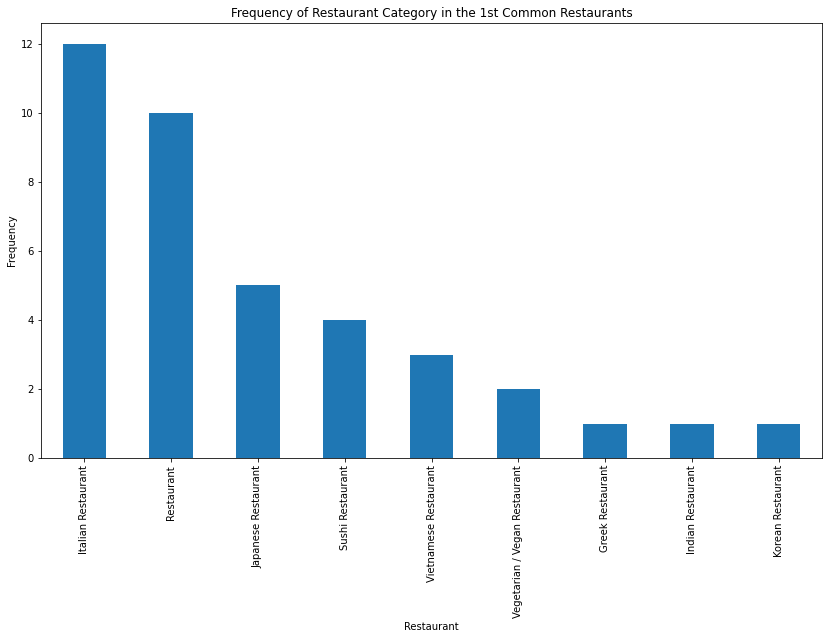

In [61]:
neighbourhoods_venues_sorted['1st Most Common Venue'].value_counts()
ax = neighbourhoods_venues_sorted['1st Most Common Venue'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Frequency of Restaurant Category in the 1st Common Restaurants")
ax.set_xlabel("Restaurant")
ax.set_ylabel("Frequency")

The graph above shows the requency of the top one restaurant category. According to the graph, we can find that the Italian restaurant is the most common restaurant among all neighbourhood following by the general type restaurant and the Japanese Restaurant. We don't see Chinese restaurant in the top one restaurant category.

Text(0, 0.5, 'Frequency')

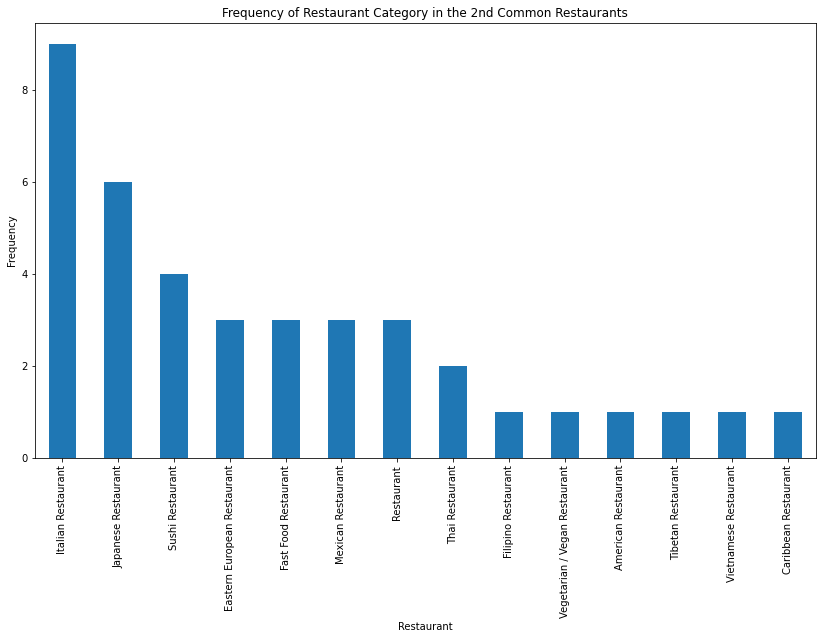

In [62]:
neighbourhoods_venues_sorted['2nd Most Common Venue'].value_counts()
ax = neighbourhoods_venues_sorted['2nd Most Common Venue'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Frequency of Restaurant Category in the 2nd Common Restaurants")
ax.set_xlabel("Restaurant")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

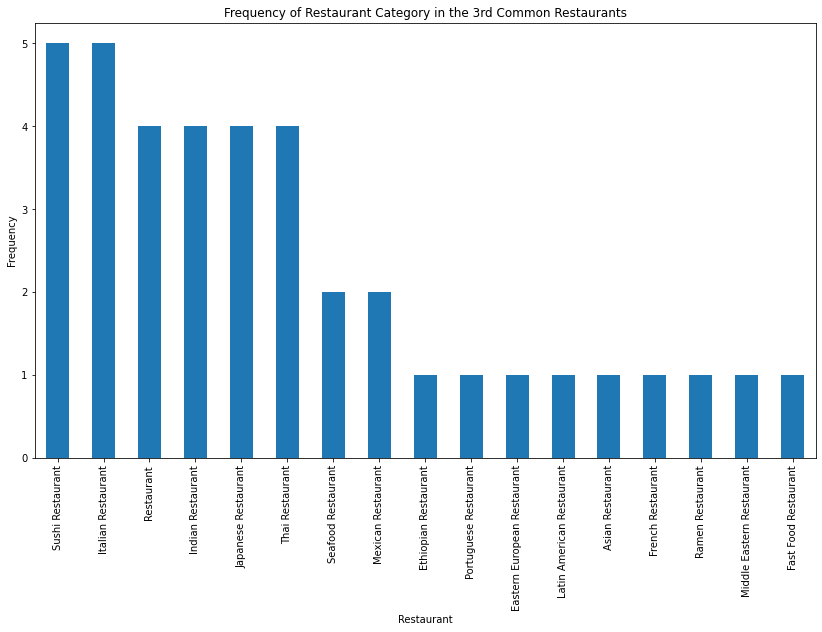

In [63]:
neighbourhoods_venues_sorted['3rd Most Common Venue'].value_counts()
ax = neighbourhoods_venues_sorted['3rd Most Common Venue'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Frequency of Restaurant Category in the 3rd Common Restaurants")
ax.set_xlabel("Restaurant")
ax.set_ylabel("Frequency")

The graphs of the 2nd and 3rd most common restaurant category show the similar pattern of the 1st graph and we can conclude that Chinese restaurant is not very common to see in Toronto. Hence, it could be a good opportunity to open a new Chinese restaurant. 

### Clustering Neighbourhoods According to Restaurant Categories

In [64]:
# set number of clusters
kclusters = 5

TorontoRestaurant_grouped_clustering = TorontoRestaurant_grouped.drop('Neighbourhood', 1)
TorontoRestaurant_grouped
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(TorontoRestaurant_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 3, 1, 0, 3, 1, 4, 0])

In [65]:
neighbourhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Restaurant,Sushi Restaurant,Japanese Restaurant,American Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Latin American Restaurant,New American Restaurant,Greek Restaurant
1,Berczy Park,Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,Comfort Food Restaurant,Middle Eastern Restaurant,French Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,American Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Restaurant,Tibetan Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,French Restaurant,Ethiopian Restaurant,Mexican Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Italian Restaurant,Fast Food Restaurant,Sushi Restaurant,American Restaurant,Thai Restaurant,French Restaurant,Restaurant,Dumpling Restaurant,Hawaiian Restaurant,Greek Restaurant
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant
5,"Cabbagetown, St. James Town",Restaurant,Japanese Restaurant,Italian Restaurant,Caribbean Restaurant,Indian Restaurant,Filipino Restaurant,Taiwanese Restaurant,Thai Restaurant,American Restaurant,German Restaurant
6,Central Bay Street,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Chinese Restaurant,Ramen Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Tapas Restaurant,Fast Food Restaurant,Mexican Restaurant
7,"Chinatown, Grange Park, Kensington Market",Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Mexican Restaurant,Ramen Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dumpling Restaurant,French Restaurant,Belgian Restaurant,Caribbean Restaurant
8,Christie,Korean Restaurant,Mexican Restaurant,Ethiopian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Vietnamese Restaurant,Ramen Restaurant,American Restaurant,Caribbean Restaurant
9,Church and Wellesley,Japanese Restaurant,Restaurant,Italian Restaurant,Thai Restaurant,Ramen Restaurant,American Restaurant,Caribbean Restaurant,Ethiopian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant


In [291]:
neighbourhoods_venues_sorted.drop(['Cluster Labels'],axis = 1)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Restaurant,Sushi Restaurant,Japanese Restaurant,American Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Latin American Restaurant,New American Restaurant,Greek Restaurant
1,Berczy Park,Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,Comfort Food Restaurant,Middle Eastern Restaurant,French Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,American Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Restaurant,Tibetan Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,French Restaurant,Ethiopian Restaurant,Mexican Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Italian Restaurant,Fast Food Restaurant,Sushi Restaurant,American Restaurant,Thai Restaurant,French Restaurant,Restaurant,Dumpling Restaurant,Hawaiian Restaurant,Greek Restaurant
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant
5,"Cabbagetown, St. James Town",Restaurant,Japanese Restaurant,Italian Restaurant,Caribbean Restaurant,Indian Restaurant,Filipino Restaurant,Taiwanese Restaurant,Thai Restaurant,American Restaurant,German Restaurant
6,Central Bay Street,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Chinese Restaurant,Ramen Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Tapas Restaurant,Fast Food Restaurant,Mexican Restaurant
7,"Chinatown, Grange Park, Kensington Market",Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Mexican Restaurant,Ramen Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dumpling Restaurant,French Restaurant,Belgian Restaurant,Caribbean Restaurant
8,Christie,Korean Restaurant,Mexican Restaurant,Ethiopian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Vietnamese Restaurant,Ramen Restaurant,American Restaurant,Caribbean Restaurant
9,Church and Wellesley,Japanese Restaurant,Restaurant,Italian Restaurant,Thai Restaurant,Ramen Restaurant,American Restaurant,Caribbean Restaurant,Ethiopian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant


In [66]:
# add clustering labels

neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = df_merged

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = pd.merge(left = neighbourhoods_venues_sorted, right = df_merged, left_on='Neighbourhood', right_on='Neighbourhood')

Toronto_merged.head() # check the last columns!

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postcode,Borough,Latitude,Longitude
0,0,"Adelaide, King, Richmond",Restaurant,Sushi Restaurant,Japanese Restaurant,American Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Latin American Restaurant,New American Restaurant,Greek Restaurant,M5H,Downtown Toronto,43.650571,-79.384568
1,0,Berczy Park,Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,Comfort Food Restaurant,Middle Eastern Restaurant,French Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,M5E,Downtown Toronto,43.644771,-79.373306
2,0,"Brockton, Exhibition Place, Parkdale Village",Restaurant,Tibetan Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,French Restaurant,Ethiopian Restaurant,Mexican Restaurant,M6K,West Toronto,43.636847,-79.428191
3,3,Business Reply Mail Processing Centre 969 Eastern,Italian Restaurant,Fast Food Restaurant,Sushi Restaurant,American Restaurant,Thai Restaurant,French Restaurant,Restaurant,Dumpling Restaurant,Hawaiian Restaurant,Greek Restaurant,M7Y,East Toronto,43.662744,-79.321558
4,1,"CN Tower, Bathurst Quay, Island airport, Harbo...",Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,M5V,Downtown Toronto,43.628947,-79.394420


In [67]:
# create map
map_clusters = folium.Map(location=[43.653963, -79.387207], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [69]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns]

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postcode,Borough,Latitude,Longitude
0,0,"Adelaide, King, Richmond",Restaurant,Sushi Restaurant,Japanese Restaurant,American Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Latin American Restaurant,New American Restaurant,Greek Restaurant,M5H,Downtown Toronto,43.650571,-79.384568
1,0,Berczy Park,Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,Comfort Food Restaurant,Middle Eastern Restaurant,French Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,M5E,Downtown Toronto,43.644771,-79.373306
2,0,"Brockton, Exhibition Place, Parkdale Village",Restaurant,Tibetan Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,French Restaurant,Ethiopian Restaurant,Mexican Restaurant,M6K,West Toronto,43.636847,-79.428191
5,0,"Cabbagetown, St. James Town",Restaurant,Japanese Restaurant,Italian Restaurant,Caribbean Restaurant,Indian Restaurant,Filipino Restaurant,Taiwanese Restaurant,Thai Restaurant,American Restaurant,German Restaurant,M4X,Downtown Toronto,43.667967,-79.367675
9,0,Church and Wellesley,Japanese Restaurant,Restaurant,Italian Restaurant,Thai Restaurant,Ramen Restaurant,American Restaurant,Caribbean Restaurant,Ethiopian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,M4Y,Downtown Toronto,43.665860,-79.383160
10,0,"Commerce Court, Victoria Hotel",Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,American Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,French Restaurant,Latin American Restaurant,Mediterranean Restaurant,M5L,Downtown Toronto,43.648198,-79.379817
14,0,"Design Exchange, Toronto Dominion Centre",Restaurant,Italian Restaurant,Japanese Restaurant,Seafood Restaurant,American Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,French Restaurant,Fast Food Restaurant,Mediterranean Restaurant,M5K,Downtown Toronto,43.647177,-79.381576
16,0,"First Canadian Place, Underground city",Japanese Restaurant,Restaurant,Italian Restaurant,Seafood Restaurant,American Restaurant,Asian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,Mediterranean Restaurant,M5X,Downtown Toronto,43.648429,-79.382280
20,0,"Harbourfront East, Toronto Islands, Union Station",Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Chinese Restaurant,Sushi Restaurant,New American Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Filipino Restaurant,M5J,Downtown Toronto,43.640816,-79.381752
23,0,"Little Portugal, Trinity",Restaurant,Italian Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Tapas Restaurant,Japanese Restaurant,Vietnamese Restaurant,Dumpling Restaurant,American Restaurant,French Restaurant,M6J,West Toronto,43.647927,-79.419750


In [70]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns]

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postcode,Borough,Latitude,Longitude
4,1,"CN Tower, Bathurst Quay, Island airport, Harbo...",Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,M5V,Downtown Toronto,43.628947,-79.394420
7,1,"Chinatown, Grange Park, Kensington Market",Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Mexican Restaurant,Ramen Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dumpling Restaurant,French Restaurant,Belgian Restaurant,Caribbean Restaurant,M5T,Downtown Toronto,43.653206,-79.400049
18,1,"Harbord, University of Toronto",Vegetarian / Vegan Restaurant,Mexican Restaurant,Restaurant,Thai Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Eastern European Restaurant,Dumpling Restaurant,Doner Restaurant,Persian Restaurant,M5S,Downtown Toronto,43.662696,-79.400049
22,1,Lawrence Park,Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,M4N,Central Toronto,43.728020,-79.388790
28,1,Rosedale,Japanese Restaurant,Filipino Restaurant,Eastern European Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Fast Food Restaurant,M4W,Downtown Toronto,43.679563,-79.377529
36,1,The Beaches,Japanese Restaurant,Caribbean Restaurant,Mexican Restaurant,Ramen Restaurant,Restaurant,Mediterranean Restaurant,French Restaurant,Greek Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,M4E,East Toronto,43.676357,-79.293031
37,1,"The Beaches West, India Bazaar",Indian Restaurant,Fast Food Restaurant,Restaurant,Italian Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,French Restaurant,Middle Eastern Restaurant,Pakistani Restaurant,M4L,East Toronto,43.668999,-79.315572
38,1,"The Danforth West, Riverdale",Greek Restaurant,Italian Restaurant,Fast Food Restaurant,Ramen Restaurant,Caribbean Restaurant,Falafel Restaurant,New American Restaurant,Cuban Restaurant,Restaurant,Chinese Restaurant,M4K,East Toronto,43.679557,-79.352188


In [71]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns]

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postcode,Borough,Latitude,Longitude
11,2,Davisville,Italian Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Restaurant,Fast Food Restaurant,Indian Restaurant,Mexican Restaurant,Ramen Restaurant,Caribbean Restaurant,French Restaurant,M4S,Central Toronto,43.704324,-79.388790
17,2,"Forest Hill North, Forest Hill West",Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Persian Restaurant,Eastern European Restaurant,Greek Restaurant,German Restaurant,M5P,Central Toronto,43.696948,-79.411307
29,2,Roselawn,Sushi Restaurant,Italian Restaurant,Japanese Restaurant,Eastern European Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,M5N,Central Toronto,43.711695,-79.416936


In [72]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns]

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postcode,Borough,Latitude,Longitude
3,3,Business Reply Mail Processing Centre 969 Eastern,Italian Restaurant,Fast Food Restaurant,Sushi Restaurant,American Restaurant,Thai Restaurant,French Restaurant,Restaurant,Dumpling Restaurant,Hawaiian Restaurant,Greek Restaurant,M7Y,East Toronto,43.662744,-79.321558
6,3,Central Bay Street,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Chinese Restaurant,Ramen Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Tapas Restaurant,Fast Food Restaurant,Mexican Restaurant,M5G,Downtown Toronto,43.657952,-79.387383
12,3,Davisville North,Italian Restaurant,Fast Food Restaurant,Sushi Restaurant,Mexican Restaurant,Restaurant,Seafood Restaurant,Chinese Restaurant,Greek Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,M4P,Central Toronto,43.712751,-79.390197
13,3,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",Sushi Restaurant,Italian Restaurant,Thai Restaurant,Restaurant,American Restaurant,Cantonese Restaurant,French Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,M4V,Central Toronto,43.686412,-79.400049
15,3,"Dovercourt Village, Dufferin",Sushi Restaurant,Italian Restaurant,Portuguese Restaurant,Brazilian Restaurant,Thai Restaurant,Fast Food Restaurant,Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,M6H,West Toronto,43.669005,-79.442259
19,3,Harbourfront,Italian Restaurant,Restaurant,Indian Restaurant,Thai Restaurant,Mexican Restaurant,Sushi Restaurant,French Restaurant,Japanese Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,M5A,Downtown Toronto,43.654260,-79.360636
21,3,"High Park, The Junction South",Italian Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Mexican Restaurant,Cajun / Creole Restaurant,Fast Food Restaurant,Indian Restaurant,Mediterranean Restaurant,Seafood Restaurant,M6P,West Toronto,43.661608,-79.464763
24,3,"Moore Park, Summerhill East",Italian Restaurant,Sushi Restaurant,Thai Restaurant,Restaurant,American Restaurant,Cantonese Restaurant,German Restaurant,Japanese Restaurant,Modern European Restaurant,Vietnamese Restaurant,M4T,Central Toronto,43.689574,-79.383160
25,3,North Toronto West,Italian Restaurant,Mexican Restaurant,Sushi Restaurant,Chinese Restaurant,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Thai Restaurant,Tapas Restaurant,Doner Restaurant,M4R,Central Toronto,43.715383,-79.405678
26,3,"Parkdale, Roncesvalles",Sushi Restaurant,Eastern European Restaurant,Thai Restaurant,Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Cuban Restaurant,Falafel Restaurant,Mediterranean Restaurant,M6R,West Toronto,43.648960,-79.456325


In [73]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns]

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postcode,Borough,Latitude,Longitude
8,4,Christie,Korean Restaurant,Mexican Restaurant,Ethiopian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Vietnamese Restaurant,Ramen Restaurant,American Restaurant,Caribbean Restaurant,M6G,Downtown Toronto,43.669542,-79.422564


### Population Analysis

I download the population distribution of each ethnic origin in the city of Toronto from the 'Demographics of Toronto' page of Wikipedia. 

In [109]:
df_Demo4 = pd.read_html('https://en.wikipedia.org/wiki/Demographics_of_Toronto')[4] 
print('The Top 20 Ethnic origins in the City of Toronto')
df_Demo4

The Top 20 Ethnic origins in the City of Toronto


,Top 20 Ethnic origins in the City of Toronto,Population (2016)[33],Percentage,Riding with Highest Concentration,Percentage.1
0,Chinese,332830,12.5,Scarborough—Agincourt,47.0
1,English,331890,12.3,Beaches—East York,24.2
2,Canadian,323175,12.0,Beaches-East York,19.7
3,Irish,262965,9.8,Parkdale—High Park,20.0
4,Scottish,256250,9.5,Beaches—East York,18.9
5,East Indian,202675,7.5,Etobicoke North,22.2
6,Italian,182495,6.8,Etobicoke Centre,15.1
7,Filipino,162605,6.0,York Centre,17.0
8,German,130900,4.9,Parkdale—High Park,9.8
9,French,122615,4.6,Parkdale—High Park,8.9


The table above shows the most prevalent ethnic origins in the City of Toronto in the year 2016 and we can see that the Chinese group with a population of 332,830 accounts for approximately 12.5% of the overall population of Toronto city. The size of the Chinese ethic origin even exceeds the English origin, which only make up 12.3% of the total population of Toronto. In addition, the table also indicates that ridings with the highest Chinese concentration are Scarborough-Agincourt where over 47% of the local population is mada up of Chinese. 

In [110]:
df_Demo8 = pd.read_html('https://en.wikipedia.org/wiki/Demographics_of_Toronto')[8]
print('Toronto & East York')
df_Demo8

Toronto & East York


,Riding,Population,Ethnic Group #1,%,Ethnic Group #2,%.1,Ethnic Group #3,%.2,Ethnic Group #4,%.3
0,Spadina-Fort York,114315,White,56.3,Chinese,14.8,South Asian,8.3,Black,5.1
1,Beaches-East York,108435,White,64.5,South Asian,10.9,Black,6.6,Chinese,5.7
2,Davenport,107395,White,66.9,Black,6.4,Chinese,5.9,Latin American,5.4
3,Parkdale-High Park,106445,White,72.4,Black,5.3,NaN,NaN,NaN,NaN
4,Toronto-Danforth,105395,White,65.5,Chinese,12.3,South Asian,5.4,Black,5.0
5,Toronto-St. Paul's,104940,White,70.8,Black,5.1,NaN,NaN,NaN,NaN
6,University-Rosedale,100520,White,66.5,Chinese,14.0,NaN,NaN,NaN,NaN
7,Toronto Centre,99590,White,48.8,South Asian,11.8,Chinese,11.1,Black,9.1


In [111]:
df_Demo9 = pd.read_html('https://en.wikipedia.org/wiki/Demographics_of_Toronto')[9]
print('North York')
df_Demo9

North York


,Riding,Population,Ethnic Group #1,%,Ethnic Group #2,%.1,Ethnic Group #3,%.2,Ethnic Group #4,%.3,Ethnic Group #5,%.4,Ethnic Group #6,%.5
0,Willowdale,117405,White,33.1,Chinese,25.3,West Asian,10.9,Korean,10.3,South Asian,5.9,Filipino,5.4
1,Eglinton-Lawrence,112925,White,67.7,Filipino,10.7,Black,5.5,NaN,NaN,NaN,NaN,NaN,NaN
2,Don Valley North,109060,Chinese,31.3,White,29.4,South Asian,10.2,West Asian,7.6,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,White,25.4,Black,22.8,Latin American,9.5,Southeast Asian,8.9,Filipino,5.5,NaN,NaN
4,York Centre,103760,White,53.1,Filipino,16.5,Black,7.9,Latin American,5.1,NaN,NaN,NaN,NaN
5,Don Valley West,101790,White,57.9,South Asian,13.3,Chinese,10.6,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,White,40.9,South Asian,17.1,Black,9.3,Chinese,7.5,Filipino,7.4,West Asian,5.5


In [112]:
df_Demo10 = pd.read_html('https://en.wikipedia.org/wiki/Demographics_of_Toronto')[10]
print('Scarborough')
df_Demo10

Scarborough


,Riding,Population,Ethnic Group #1,%,Ethnic Group #2,%.1,Ethnic Group #3,%.2,Ethnic Group #4,%.3,Ethnic Group #5,%.4
0,Scarborough Centre,110450,White,29.4,South Asian,25.6,Filipino,12.5,Black,9.6,Chinese,9.3
1,Scarborough Southwest,108295,White,42.0,South Asian,21.6,Black,11.2,Filipino,9.0,Chinese,5.8
2,Scarborough-Agincourt,104225,Chinese,45.8,White,19.1,South Asian,14.0,Black,6.3,Filipino,5.4
3,Scarborough-Rouge Park,101445,South Asian,32.6,White,26.8,Black,15.9,Filipino,8.7,NaN,NaN
4,Scarborough-Guildwood,101115,South Asian,33.2,White,27.6,Black,14.3,Filipino,7.9,Chinese,5.4
5,Scarborough North,97610,Chinese,45.0,South Asian,26.1,Black,7.6,White,7.6,Filipino,6.4


In [113]:
df_Demo11 = pd.read_html('https://en.wikipedia.org/wiki/Demographics_of_Toronto')[11]
print('Etobicoke & York')
df_Demo11

Etobicoke & York


,Riding,Population,Ethnic Group #1,%,Ethnic Group #2,%.1,Ethnic Group #3,%.2,Ethnic Group #4,%.3,Ethnic Group #5,%.4
0,Etobicoke-Lakeshore,127520,White,71.3,South Asian,5.5,Black,5.0,NaN,NaN,NaN,NaN
1,Etobicoke North,116960,South Asian,28.9,White,23.8,Black,23.4,NaN,NaN,NaN,NaN
2,Etobicoke Centre,116055,White,72.3,South Asian,5.9,Black,5.9,NaN,NaN,NaN,NaN
3,York South-Weston,115130,White,44.2,Black,23.2,Latin American,8.5,Filipino,5.9,South Asian,5.7


According the tables above, we can notice that Scarborough district has the highest concentration of the Chinese ethnic group. Therefore, opening a Chinese restaurant in Scarborough can be very benefitial by attracting a great number of local customers.

# Conclusion

Based on my analysis, opening a new Chinese restaurant in Toronto is a good opportunity. First, Toronto is a multicultural city which has a wide range of restaurant categories. Hence, a new Chinese restaurant will be easily accepted by local people. Second, Chinese restaurants are not very common in this city indicating less competition pressure from peer members. Third, districts such as Scarborough have a great number of Chinese residents providing good customer basis for a new restaurant. Therefore, it can be a good choice to start up a new Chinese restaurant in Toronto. However, selecting areas such as downtown Toronto may also be risky as the competition from other restaurant categories such as Italian and Japanese restaurants can also be very serious.    